In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    roc_curve, auc, precision_score, recall_score, f1_score
)
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns


In [25]:
IMG_SIZE = 128
BATCH_SIZE = 32

train_dir = r"C:\New Volume\DIAT\CIC\Tumor Detection (Classification)\Training"
test_dir = r"C:\New Volume\DIAT\CIC\Tumor Detection (Classification)\Testing"

datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary')
test_data = datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary',shuffle=False)


Found 5712 images belonging to 2 classes.
Found 1311 images belonging to 2 classes.


In [26]:
# Compute class weights

train_labels = train_data.classes
class_weights_dict = dict(enumerate(class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)))

print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.7905956112852666, 1: 0.6937090114160797}


In [29]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary output
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

C:\Users\Aman\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,288,705 (16.36 MB)

 Trainable params: 4,288,257 (16.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [31]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=15,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)


C:\Users\Aman\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.8923 - loss: 0.3774 - val_accuracy: 0.6918 - val_loss: 1.4532
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.9662 - loss: 0.1231 - val_accuracy: 0.8772 - val_loss: 0.2972
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.9739 - loss: 0.0799 - val_accuracy: 0.9291 - val_loss: 0.1513
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 150s 835ms/step - accuracy: 0.9777 - loss: 0.0584 - val_accuracy: 0.9710 - val_loss: 0.0776
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 148s 825ms/step - accuracy: 0.9787 - loss: 0.0522 - val_accuracy: 0.9779 - val_loss: 0.0571
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 201s 819ms/step - accuracy: 0.9874 - loss: 0.0404 - val_accuracy: 0.9901 - val_loss: 0.0287
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 147s 821ms/step - accuracy: 0.9911 - loss: 0.0251 - val_accuracy: 0.9931 - val_loss: 0.0263
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 147s 819ms/step - accuracy: 0.9914 - loss: 0.

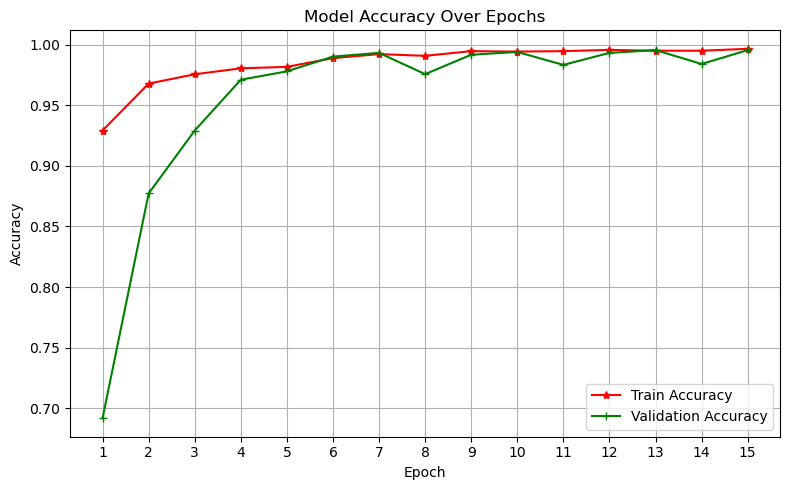

In [33]:
# Model Accuracy plot

epochs = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, history.history['accuracy'], 'r-*',label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'],'g-+' , label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.xticks(epochs)  # Force ticks to match epoch numbers
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

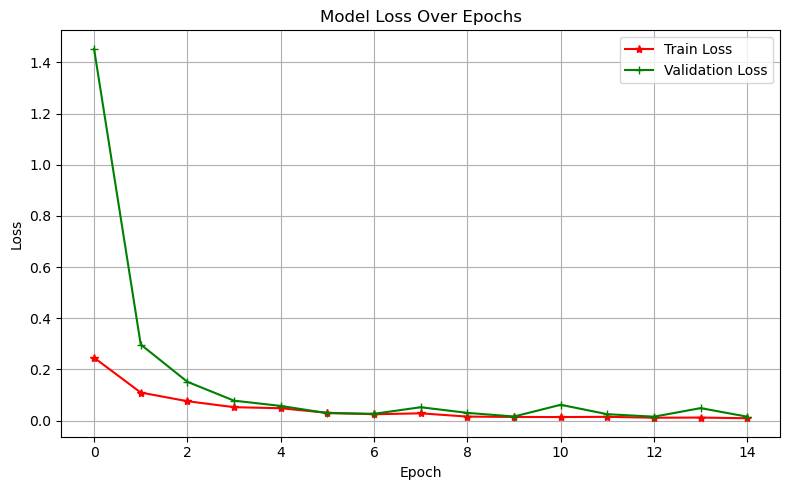

In [35]:
# Model loss plot

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'],'r-*', label='Train Loss')
plt.plot(history.history['val_loss'],'g-+' , label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 304ms/step


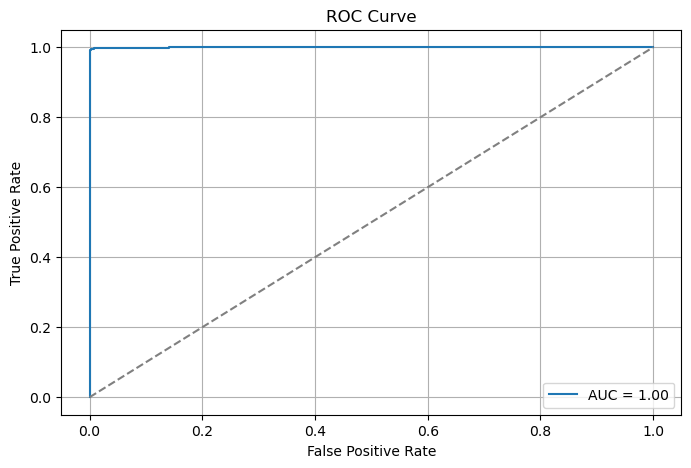

In [37]:
# ROC Curve + AUC

y_true = test_data.classes
y_probs = model.predict(test_data).flatten()

fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


In [39]:
# Classification report for threshold value 0.5
t = 0.5

y_pred = (y_probs > t).astype(int)
print(f"\n🔹 Classification Report for Threshold = {t}")
print(classification_report(y_true, y_pred, target_names=['no_tumor', 'tumor']))



🔹 Classification Report for Threshold = 0.5
              precision    recall  f1-score   support

    no_tumor       0.99      1.00      0.99       405
       tumor       1.00      0.99      1.00       906

    accuracy                           1.00      1311
   macro avg       0.99      1.00      0.99      1311
weighted avg       1.00      1.00      1.00      1311



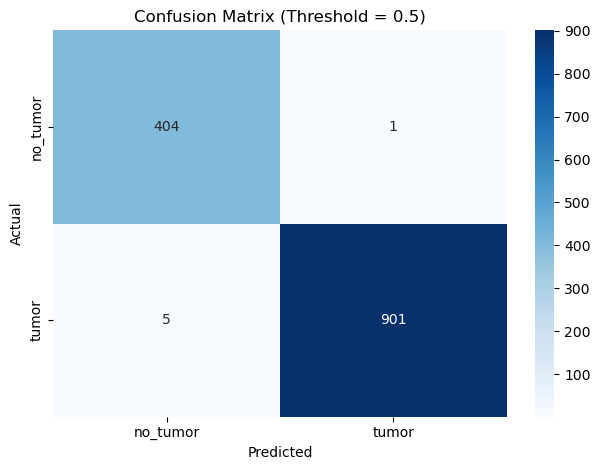

In [43]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['no_tumor', 'tumor'],
            yticklabels=['no_tumor', 'tumor'])
plt.title(f'Confusion Matrix (Threshold = {t})')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


C:\Users\Aman\AppData\Local\Temp\ipykernel_33536\1258314416.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label = class_names[int(predictions[i])]


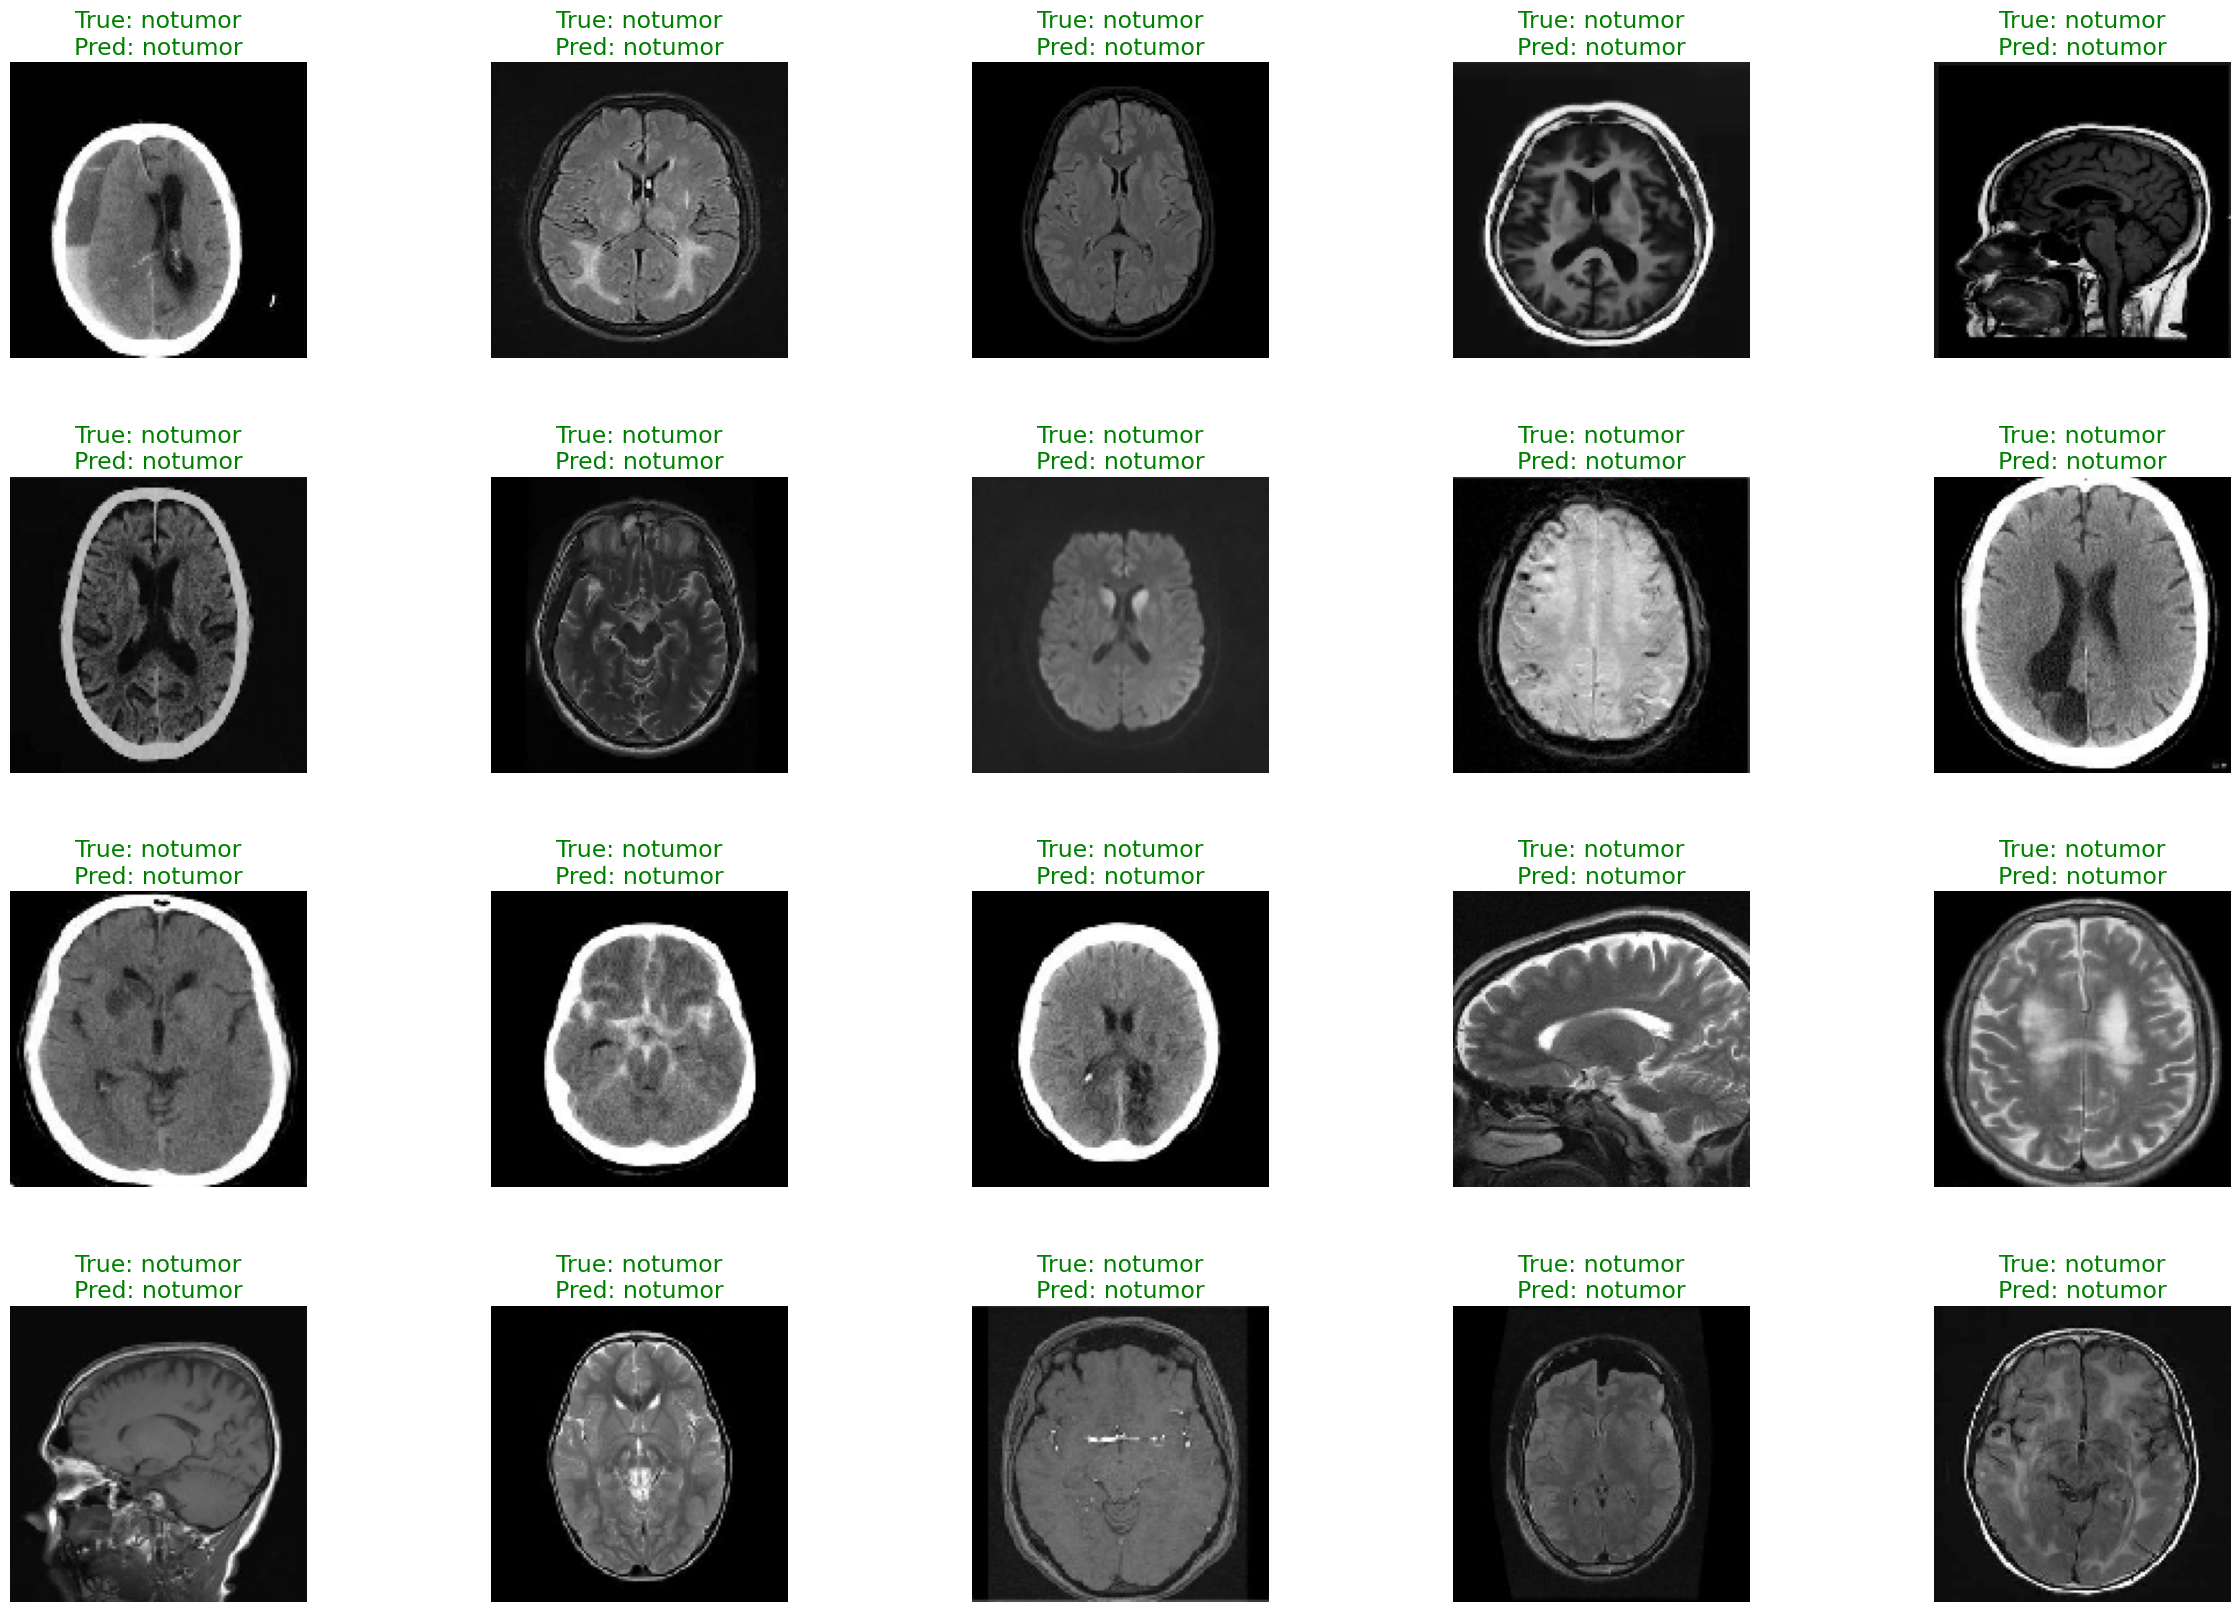

In [45]:
import matplotlib.pyplot as plt

class_names = list(test_data.class_indices.keys())

# Reset generator to start from the beginning
test_data.reset()

plt.figure(figsize=(30, 20))

plot_index = 1
images_shown = 20

while plot_index <= images_shown:
    x_batch, y_batch = next(test_data)
    predictions = (model.predict(x_batch) > 0.5).astype("int32")

    for i in range(len(x_batch)):
        if plot_index > images_shown:
            break
        plt.subplot(4, 5, plot_index)
        plt.imshow(x_batch[i])
        true_label = class_names[int(y_batch[i])]
        pred_label = class_names[int(predictions[i])]
        color = "green" if true_label == pred_label else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=17) 
        plt.axis('off')
        plot_index += 1

plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()


In [ ]:
model.save("tumor_classifier_model.h5")